# Yelp Rating Predictor Hybrid Model

Help for making arguments: The point in the hybrid model paper is to consider situations where you have low volumes of training 
data and have 
Description

#TODO


#### Load Data

In [102]:
import pandas as pd
yelp = pd.read_csv('../2_text_preprocessing/cleaned_data_yelp.csv')

## First Model: Sentiment Scoring using Textblob

In [103]:
# pip install -U textblob-de
# python -m textblob.download_corpora
from textblob_de import TextBlobDE as TextBlob
import pandas as pd

#### Compute sentiment score per comment

In [104]:
def compute_sentiscore(text):
    blob=TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

In [105]:
yelp['Senti_Blob'] = yelp['Lemmatized_Comment'].apply(lambda x: compute_sentiscore(x))
yelp['Senti_Blob_Tokenized'] = yelp['Tokenized_Comment'].apply(lambda x: compute_sentiscore(x))
#yelp['Senti_Blob_Clean'] = yelp['Clean_Comment'].apply(lambda x: compute_sentiscore(x))
#yelp['Senti_Blob_Comment'] = yelp['Comment'].apply(lambda x: compute_sentiscore(x))

#### Scale Sentiblob to Rating Range 1-5

In [106]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1,5))
# Create Array with specific dimension requirements to make scaler happy
senti_blob_ar= (yelp['Senti_Blob'].values).reshape(-1, 1)
Senti_Blob_scaled = pd.DataFrame(scaler.fit_transform(senti_blob_ar),columns=['Senti_norm'])
# Create Array with specific dimension requirements to make scaler happy
senti_blob_ar= (yelp['Senti_Blob_Tokenized'].values).reshape(-1, 1)
Senti_Blob_scaled_Tokenized = pd.DataFrame(scaler.fit_transform(senti_blob_ar),columns=['Senti_norm_Tokenized'])
# Create Array with specific dimension requirements to make scaler happy
#senti_blob_ar= (yelp['Senti_Blob_Clean'].values).reshape(-1, 1)
#Senti_Blob_scaled_Clean = pd.DataFrame(scaler.fit_transform(senti_blob_ar),columns=['Senti_norm_Clean'])
# Create Array with specific dimension requirements to make scaler happy
#senti_blob_ar= (yelp['Senti_Blob_Comment'].values).reshape(-1, 1)
#Senti_Blob_scaled_Comment = pd.DataFrame(scaler.fit_transform(senti_blob_ar),columns=['Senti_norm_Comment'])
#yelp = pd.concat([yelp,Senti_Blob_scaled,Senti_Blob_scaled_Tokenized,Senti_Blob_scaled_Clean,Senti_Blob_scaled_Comment],axis=1)
yelp = pd.concat([yelp,Senti_Blob_scaled,Senti_Blob_scaled_Tokenized],axis=1)

#### Comparison Rating vs. TextBlob Sentiscore

In [107]:
#Senti_Blob_scaled.plot.hist(grid=True, bins=5)

In [108]:
#yelp['Rating'].plot.hist(grid=True, bins=5)

In [109]:
yelp.to_csv('yelp_cleaned_sentiscored.csv',header=True, index=False)

## Second Model: TF-IDF Regression

In [110]:
yelp = pd.read_csv('yelp_cleaned_sentiscored.csv')

In [111]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plot

In [112]:
# Q: https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
# setting lower and upper frequency thresholds as done in reference paper Luo, Xu
# max_features: int, default=None --> If not None, build a vocabulary that only considers the top
# max_features ordered by term frequency across the corpus
# max/min_df: ignore terms that have a document frequency strictly higher/lower than given threshold
# doc_frequency=0.8
# min_absolute_frequency=5
# max_features = 15000
# norm='l2'
#tfidf = TfidfVectorizer(min_df=min_absolute_frequency, max_df=doc_frequency)
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(yelp['Tokenized_Comment'])
#X_tfidf = tfidf.fit_transform(yelp['Clean_Comment'])
#X_tfidf = tfidf.fit_transform(yelp['Lemmatized_Comment'])
#print(X_tfidf)
y = yelp['Rating']
X_tfidf.shape

(9706, 44432)

#### Split TF-IDF dataset in train-dev-test using seed

In [113]:
from sklearn.model_selection import train_test_split
# Set a seed to guarantee same records for train, dev and test datasets are used
seed=42
X_train, X_rest, y_train, y_rest = train_test_split(X_tfidf, y, test_size = 0.2, random_state=seed)
X_test, X_dev, y_test, y_dev = train_test_split(X_rest, y_rest, test_size = 0.5, random_state=seed)

#### Dealing with an imbalanced Dataset: Classes 1, 2 and 3 are underrepresented in our corpus

Due to the size of the present corpus, we chose to resample the train dataset using: oversampling and combined under-and oversampling.
2 Oversampling Methods are tested below: Random Oversampler, ADASYN (Adaptive Synthetic Sampling).
SMOTETomek (SMOTE + Tomek Link Removal) was chosen for combined under-and oversampling.

Q:
https://medium.com/analytics-vidhya/re-sampling-imbalanced-training-corpus-for-sentiment-analysis-c9dc97f9eae1
https://imbalanced-learn.org/stable/references/index.html

In [114]:
#yelp['Rating'].plot.hist(grid=True, bins=5)

In [115]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek

In [116]:
#Random Oversampler duplicates entries for minority classes
ros = RandomOverSampler(random_state=42)
ROS_X_train, ROS_y_train = ros.fit_resample(X_train, y_train)

In [117]:
# Adaptive synthetic sampling generates additional data for minority class samples which are more difficult to learn
ad = ADASYN(random_state=42)
ad_X_train, ad_y_train = ad.fit_resample(X_train, y_train)

In [118]:
smtom = SMOTETomek(random_state=42)
tom_X_train, tom_y_train = smtom.fit_resample(X_train, y_train)

#### Comparison of dataset size after re-sampling

In [119]:
pd.DataFrame({'Baseline':pd.Series(y_train).value_counts(),
              'ROS':pd.Series(ROS_y_train).value_counts(),
              'ADASYN':pd.Series(ad_y_train).value_counts(),
              'SMOTETomek':pd.Series(tom_y_train).value_counts()})

,Baseline,ROS,ADASYN,SMOTETomek
1,393,3688,3769,3688
2,470,3688,3835,3688
3,992,3688,3681,3688
4,2221,3688,4044,3682
5,3688,3688,3688,3682


### Selection of best regression model for TF-IDF-based Prediction of "Rating"

For all types of resampled datasets .... using Regressors... Function...

https://www.simplilearn.com/tutorials/scikit-learn-tutorial/sklearn-regression-models

In [120]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.dummy import DummyRegressor
regressors = [LinearRegression(),
              SGDRegressor(), #Stochastic Gradient Descent Regression
              Ridge(),
              Lasso(),
              LinearSVR(),#Support Vector Machine
              DummyRegressor()]

In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error
import time

def model_eval(xtrain,ytrain,reg_list=regressors):
    Name = []
    mae=[]
    mse = []
    maxerr=[]
    Time_Taken = []
    current_min=4
    best_model=reg_list[0] ; best_pred=[] ; best_name=LinearRegression()

    for model in reg_list:
        model = model
        name = str(model)
        Name.append(name)
        begin = time.time()
        #train
        model.fit(xtrain,ytrain)
        #validate/predict
        prediction = model.predict(X_dev)
        end = time.time()
        if mean_absolute_error(y_dev,prediction) < current_min:
            current_min = mean_absolute_error(y_dev,prediction)
            best_model = model
            best_name = name
            best_pred = prediction
        mse.append(mean_squared_error(y_dev,prediction))
        mae.append(mean_absolute_error(y_dev,prediction))
        maxerr.append(max_error(y_dev,prediction))
        Time_Taken.append(end-begin)
        print(name + ' Successfully Trained')

    Dict = {'Regressor':Name,'MAE':mae,'MSE':mse,'Max. Error':maxerr,'Time Taken':Time_Taken}
    model_df = pd.DataFrame(Dict)
    #sort by MAE for better visibility
    model_df=model_df.sort_values(by=['MAE'], ascending=True, ignore_index=True)

    return [best_model,best_pred,best_name,model_df,mae,mse,maxerr,Time_Taken]

#### Training regressors using the baseline train dataset

In [122]:
results_baseline = model_eval(xtrain = X_train, ytrain = y_train)
results_baseline[3]

LinearRegression() Successfully Trained
SGDRegressor() Successfully Trained
Ridge() Successfully Trained
Lasso() Successfully Trained
LinearSVR() Successfully Trained
DummyRegressor() Successfully Trained


,Regressor,MAE,MSE,Max. Error,Time Taken
0,Ridge(),0.638093,0.689512,3.570621,0.051284
1,LinearSVR(),0.645261,0.735368,4.022919,0.082633
2,SGDRegressor(),0.817099,1.036587,3.280426,0.376224
3,Lasso(),0.902294,1.340634,3.074317,0.467050
4,DummyRegressor(),0.902294,1.340634,3.074317,0.001002
5,LinearRegression(),0.950819,1.436604,5.040079,3.287895


#### Training regressors using the ROS re-sampled train dataset

In [123]:
results_ros = model_eval(xtrain = ROS_X_train, ytrain = ROS_y_train)
results_ros[3]

LinearRegression() Successfully Trained
SGDRegressor() Successfully Trained
Ridge() Successfully Trained
Lasso() Successfully Trained
LinearSVR() Successfully Trained
DummyRegressor() Successfully Trained


,Regressor,MAE,MSE,Max. Error,Time Taken
0,Ridge(),0.678258,0.736699,3.503422,0.145004
1,LinearSVR(),0.700329,0.794375,3.933126,0.512385
2,SGDRegressor(),0.905062,1.204543,2.943334,1.069159
3,LinearRegression(),0.948034,1.428617,5.018966,10.646540
4,Lasso(),1.375901,2.403708,2.000000,1.128304
5,DummyRegressor(),1.375901,2.403708,2.000000,0.000000


#### Training regressors using the ADASYN re-sampled train dataset

In [124]:
results_adasyn = model_eval(xtrain = ad_X_train, ytrain = ad_y_train)
results_adasyn[3]

LinearRegression() Successfully Trained
SGDRegressor() Successfully Trained
Ridge() Successfully Trained
Lasso() Successfully Trained
LinearSVR() Successfully Trained
DummyRegressor() Successfully Trained


,Regressor,MAE,MSE,Max. Error,Time Taken
0,Ridge(),0.678321,0.739192,3.556014,0.195694
1,LinearSVR(),0.709741,0.809988,3.878913,4.013542
2,SGDRegressor(),0.906647,1.208220,2.986385,1.206519
3,LinearRegression(),0.948040,1.428655,5.015484,15.035655
4,Lasso(),1.374718,2.398613,2.002471,1.145572
5,DummyRegressor(),1.374718,2.398613,2.002471,0.000000


#### Training regressors using the SMOTETomek re-sampled train dataset

In [125]:
results_smote = model_eval(xtrain = tom_X_train, ytrain = tom_y_train)
results_smote[3]

LinearRegression() Successfully Trained
SGDRegressor() Successfully Trained
Ridge() Successfully Trained
Lasso() Successfully Trained
LinearSVR() Successfully Trained
DummyRegressor() Successfully Trained


,Regressor,MAE,MSE,Max. Error,Time Taken
0,Ridge(),0.677225,0.735660,3.475313,0.202185
1,LinearSVR(),0.709363,0.807069,3.859641,2.921110
2,SGDRegressor(),0.902671,1.198772,3.016103,1.180828
3,LinearRegression(),0.945974,1.422351,5.006298,15.415360
4,Lasso(),1.376638,2.405724,2.000977,1.245598
5,DummyRegressor(),1.376638,2.405724,2.000977,0.000000


In [126]:
best_model = results_adasyn[0]
y_pred_tfidf = best_model.predict(X_tfidf)

#### Predict Ratings for all comments using Ridge Regression and save to CSV

In [127]:
#Add columns with prediction results from TF-IDF: raw results, scaled results
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1,5))
y_pred_tfidf_reshaped = (y_pred_tfidf).reshape(-1, 1)
df_tfidf_pred = pd.DataFrame(y_pred_tfidf, columns=['TFIDF_res'])
df_tfidf_pred_scaled = pd.DataFrame(scaler.fit_transform(y_pred_tfidf_reshaped),columns=['TFIDF_res_scaled'])

yelp = pd.concat([yelp, df_tfidf_pred, df_tfidf_pred_scaled],axis=1)

#### Visualizing Best Regressor: Ridge Regressor using ADASYN re-sampling

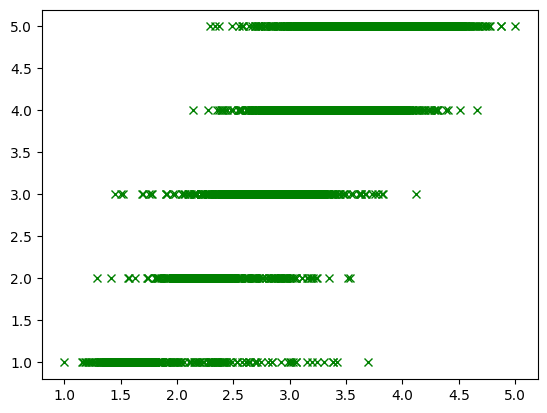

In [128]:
plot.plot(yelp.TFIDF_res_scaled, yelp.Rating, 'x', color='green')

In [129]:
yelp.to_csv('yelp_cleaned_sentiscored.csv',header=True, index=False)

## Third Model: LSTM Rating Classifier using GloVe Word Embeddings

Q:
https://www.youtube.com/watch?v=nam2zR7p7Os
https://www.youtube.com/watch?v=Wp-Wb456kSU
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing
https://keras.io/examples/nlp/pretrained_word_embeddings/
https://www.youtube.com/watch?v=ivqXiW0X42Q&ab_channel=SherMuhammadDaudpota
https://www.kaggle.com/code/francoisdubois/build-a-word-embedding-with-glove-matrix/notebook

In [130]:
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from numpy import asarray, array
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, Dropout
import matplotlib.pyplot as plt
from keras import optimizers
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,classification_report, balanced_accuracy_score

In [131]:
yelp = pd.read_csv('yelp_cleaned_sentiscored.csv')

#### Load GloVe Word Embeddings

Use pretrained Vectors for German. Download at: https://www.deepset.ai/german-word-embeddings

In [132]:
#fill dictionary with GloVe words and their embeddings
embedding_dict = {}

with open("vectors.txt", "r",encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = asarray(values[1:33], 'float32')
        embedding_dict[word] = vectors
f.close()
print('Found %s word vectors.' % len(embedding_dict))
#print(embedding_dict.get("der"))

Found 1309281 word vectors.


#### Encode and Pad Yelp Lemmatized Comments

In [133]:
comments_array = asarray(yelp['Lemmatized_Comment'])
vocab_size = 1700 #20000
tokenizer=Tokenizer()
# Include Comments in Tokenizer
tokenizer.fit_on_texts(comments_array)
# get index per word

tokenizer.word_index = {key.replace("'", ""):val for key, val in tokenizer.word_index.items()}
#print(tokenizer.word_index)
word_index = tokenizer.word_index

In [134]:
encoded_comments = tokenizer.texts_to_sequences(comments_array)
#print(encoded_comments[104:105])
padding_size=300
padded_cmts = pad_sequences(encoded_comments, maxlen=padding_size)

#### Create GloVe Embedding Matrix for Yelp Comments Vocabulary

In [135]:
num_words = len(word_index) + 2
#num_words = vocab_size
embedding_dim = 32
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if (embedding_vector is not None) and (len(embedding_vector) == embedding_dim):
        # Words not found in GloVe embedding dictionary will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Colums in GloVe Embedding Matrix: %d" % len(embedding_matrix))
print("Converted %d words (%d misses)" % (hits, misses))

Colums in GloVe Embedding Matrix: 39097
Converted 23046 words (16049 misses)


#### One-Hot Encoding of Rating
Q: https://www.atmosera.com/blog/multiclass-classification-with-neural-networks/

In [136]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# need to pre-encode labels (1-5) to (0-4) because if we do to_categorical only later on  we end up with six levels instead of 5
# fit transform solves this issue
yelp['Rating_Encoded'] = LabelEncoder().fit_transform(yelp['Rating'])
# print(yelp.Rating)
# print(to_categorical(yelp.Rating))

#### Split LSTM dataset in train-dev-test using seed
Q:
https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c

In [137]:
# Get 20% of total data as non-training data
y= yelp['Rating_Encoded']
X_train, X_rest, y_train, y_rest = train_test_split(padded_cmts, y, test_size = 0.2, random_state=seed)

# Partition those 20% half into validation data and half into test data, resulting in 10% of total data for each
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, random_state=seed)

#### Define LSTM Model

Q:
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

https://keras.io/examples/nlp/pretrained_word_embeddings/

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [138]:
# This callback will stop the training when there is no improvement in
# loss/accuracy for 'patience' parameter many consecutive epochs.
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=0)

model = Sequential()


# Include pre-trained GloVe Word Embeddings
model.add(Embedding(
    input_dim = num_words,
    #embedding_dim = dim of matrix glove vectors x our dictionary
    output_dim = embedding_dim,
    embeddings_initializer = Constant(embedding_matrix),
    input_length = padding_size,
    trainable = True))

# Randomly drop nodes from network layer in different iterations to prevent overfitting
model.add(Dropout(rate=0.2))
# LSTM layer
model.add(LSTM(units=16, activation='tanh'))

# Compress information into 5 dimensional layer, scaling into probabilities for each Rating class with the Softmax function
model.add(Dense(units=5, activation='softmax'))
opt = optimizers.Adam(learning_rate=5e-03)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 32)           1251104   
                                                                 
 dropout_2 (Dropout)         (None, 300, 32)           0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,254,325
Trainable params: 1,254,325
Non-trainable params: 0
_________________________________________________________________


#### Train LSTM Model

https://www.youtube.com/watch?v=Qsmn9pL5kcU

In [139]:
hist = model.fit(X_train,
                 to_categorical(y_train),
                 #batch_size=16,
                 epochs=5,
                 callbacks=[earlyStopping],
                 validation_data=(X_dev,to_categorical(y_dev)))

Epoch 1/5
243/243 [==============================] - 56s 223ms/step - loss: 1.2300 - accuracy: 0.4799 - val_loss: 1.0868 - val_accuracy: 0.5376
Epoch 2/5
243/243 [==============================] - 44s 182ms/step - loss: 0.9024 - accuracy: 0.6252 - val_loss: 0.9572 - val_accuracy: 0.5901


In [140]:
#print(hist.history.keys())
pred_test= np.argmax(model.predict(X_test), axis=1)
#print(pred_test[:300])
print(balanced_accuracy_score(pred_test,y_test))
print(classification_report(y_test,pred_test))

31/31 [==============================] - 2s 45ms/step
0.46492746921549133
              precision    recall  f1-score   support

           0       0.52      0.27      0.36        48
           1       0.28      0.23      0.25        71
           2       0.34      0.37      0.35       134
           3       0.46      0.43      0.45       267
           4       0.73      0.80      0.76       451

    accuracy                           0.57       971
   macro avg       0.46      0.42      0.43       971
weighted avg       0.56      0.57      0.56       971



#### Show Loss across epochs

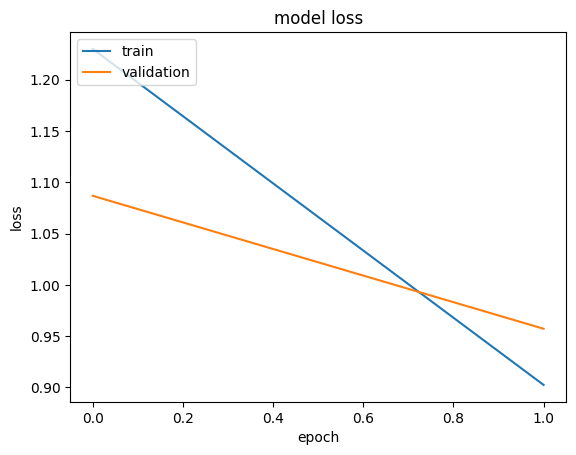

In [141]:
plot.plot(hist.history['loss'])
plot.plot(hist.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'validation'], loc='upper left')
plot.show()

In [142]:
#yelp.drop(['LSTM','LSTM_scaled'],inplace=True,axis=1)

In [143]:
# Get Predictions on the full dataset (includes Train, Dev, Test predictions)
lstm_pred = np.argmax(model.predict(padded_cmts), axis=1)

# Re-code Rating prediction from 0-4 back to 0-5 range by adding 1 and saving as dataframe to join with main Yelp dataset
df_lstm_pred_scaled = pd.DataFrame(data = lstm_pred, columns = ["LSTM"])
df_lstm_pred = pd.DataFrame(data = lstm_pred + 1, columns = ["LSTM_scaled"])
yelp = pd.concat([yelp, df_lstm_pred_scaled ,df_lstm_pred],axis=1)

# print(np.argmax(lstm_pred, axis=1)[1])

304/304 [==============================] - 15s 48ms/step


## Yelp Predictor Rating Hybrid Model: Putting the three models together

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import balanced_accuracy_score , classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score, explained_variance_score, r2_score, mean_squared_error, max_error
from sklearn.metrics import balanced_accuracy_score , classification_report, confusion_matrix, ConfusionMatrixDisplay

#### Split dataset in train-dev-test using seed

In [145]:
yelp.columns

Index(['Comment', 'Rating', 'Clean_Comment', 'Tokenized_Comment',
       'Lemmatized_Comment', 'Senti_Blob', 'Senti_Blob_Tokenized',
       'Senti_norm', 'Senti_norm_Tokenized', 'TFIDF_res', 'TFIDF_res_scaled',
       'Rating_Encoded', 'LSTM', 'LSTM_scaled'],
      dtype='object')

In [146]:
check=yelp[['Rating','TFIDF_res_scaled','Senti_norm','LSTM_scaled']]
check[55:66]

,Rating,TFIDF_res_scaled,Senti_norm,LSTM_scaled
55,5,3.593639,4.090909,5
56,4,3.496255,3.750000,4
57,4,3.870625,5.000000,4
58,5,4.272262,4.150000,5
59,4,3.830468,3.300000,5
60,5,3.933024,4.400000,5
61,5,3.684782,4.828571,5
62,4,3.339877,5.000000,4
63,4,3.863128,4.257143,5
64,1,1.397426,1.000000,1


In [147]:
hybrid_x = yelp[['TFIDF_res','Senti_Blob','LSTM']]
#combinations: 
# 'TFIDF_res_scaled','Senti_Blob','LSTM_scaled' | 'TFIDF_res','Senti_Blob','LSTM_scaled'
# 'TFIDF_res_scaled','Senti_Blob_Tokenized','LSTM_scaled'| 'TFIDF_res','Senti_Blob_Tokenized','LSTM_scaled'
# 'TFIDF_res_scaled','Senti_Blob','LSTM' | 'TFIDF_res','Senti_Blob','LSTM'
# 'TFIDF_res','Senti_Blob_Tokenized','LSTM' | 'TFIDF_res_scaled','Senti_Blob_Tokenized','LSTM'
# 'TFIDF_res','Senti_Blob_Tokenized','LSTM'
y = yelp['Rating']

# Get 20% of total data as non-training data
X_train, X_rest, y_train, y_rest = train_test_split(hybrid_x, y, test_size = 0.2, random_state=seed)

# Partition those 20% half into validation data and half into test data, resulting in 10% of total data for each
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, random_state=seed)

In [148]:
hybrid_x.columns

Index(['TFIDF_res', 'Senti_Blob', 'LSTM'], dtype='object')

### Selection of best classifier model for Hybrid Prediction of "Rating"

In [149]:
classifiers = [LogisticRegression(),
               KNeighborsClassifier(),
               #ComplementNB(),
               SVC(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               DummyClassifier()]

In [150]:
def class_eval(xtrain,ytrain,class_list=classifiers):
    Name = []
    Accuracy = []
    Accuracy_bal = []
    Precision = []
    F1_Score = []
    Recall = []
    Time_Taken = []
    current_max=0

    for model in class_list:
        model = OneVsRestClassifier(model)
        name = str(model)
        Name.append(name)
        begin = time.time()
        model.fit(xtrain,ytrain)
        prediction = model.predict(X_dev)
        end = time.time()

        if balanced_accuracy_score(prediction,y_dev) > current_max:
            current_max = balanced_accuracy_score(prediction,y_dev)
            best_model = model
            best_name = name
            best_pred = prediction
            best_matrix = confusion_matrix(prediction,y_dev)

        Accuracy.append(accuracy_score(prediction,y_dev))
        Accuracy_bal.append(balanced_accuracy_score(prediction,y_dev))
        Precision.append(precision_score(prediction,y_dev,average = 'macro'))
        Recall.append(recall_score(prediction,y_dev,average = 'macro'))
        F1_Score.append(f1_score(prediction,y_dev,average = 'macro'))
        Time_Taken.append(end-begin)
        print(name + ' Successfully Trained')

    Dict = {'Name':Name,
            'Balanced Acc.':Accuracy_bal,
            'Accuracy':Accuracy,          
            'Precision':Precision,
            'F1Score':F1_Score,
            'Recall':Recall,
            'Time Taken':Time_Taken}
    model_df = pd.DataFrame(Dict)
    model_df=model_df.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)

    return [best_model,best_pred,best_name,best_matrix,model_df,Name,Accuracy,Precision,F1_Score,Recall,Time_Taken]

#### Train classifiers and compare results

In [151]:
hybrid = class_eval(xtrain = X_train, ytrain = y_train, class_list = classifiers)
hybrid[4]

OneVsRestClassifier(estimator=LogisticRegression()) Successfully Trained
OneVsRestClassifier(estimator=KNeighborsClassifier()) Successfully Trained
OneVsRestClassifier(estimator=SVC()) Successfully Trained
OneVsRestClassifier(estimator=DecisionTreeClassifier()) Successfully Trained
OneVsRestClassifier(estimator=RandomForestClassifier()) Successfully Trained
OneVsRestClassifier(estimator=DummyClassifier()) Successfully Trained


C:\Users\ana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
C:\Users\ana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\ana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\ana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Name,Balanced Acc.,Accuracy,Precision,F1Score,Recall,Time Taken
0,OneVsRestClassifier(estimator=SVC()),0.503180,0.599382,0.462183,0.472486,0.503180,5.852169
1,OneVsRestClassifier(estimator=LogisticRegressi...,0.442446,0.548919,0.342229,0.347491,0.442446,0.276514
2,OneVsRestClassifier(estimator=KNeighborsClassi...,0.458878,0.547889,0.423896,0.430663,0.458878,0.200583
3,OneVsRestClassifier(estimator=DecisionTreeClas...,0.460352,0.546859,0.419037,0.431814,0.460352,0.167893
4,OneVsRestClassifier(estimator=RandomForestClas...,0.454784,0.534501,0.422925,0.429563,0.454784,6.896317
5,OneVsRestClassifier(estimator=DummyClassifier()),0.469619,0.469619,0.200000,0.127821,0.093924,0.012228


### HyperTuning

https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

In [152]:
# Since cross-validation is performed we don't need the Train - Dev/Val split
X_train_tune = pd.concat([X_train,X_dev])
y_train_tune = pd.concat([y_train,y_dev])
print(len(X_train_tune))
print(y_train_tune.value_counts())
print(X_train_tune.head())

8735
5    4144
4    2495
3    1123
2     531
1     442
Name: Rating, dtype: int64
      TFIDF_res  Senti_Blob  LSTM
4104   4.554079    0.755556     4
3058   3.747116    0.406250     3
7372   3.863558    0.429032     2
7588   4.576150    0.000000     4
393    2.962123    0.671429     2


In [153]:
# Create pipelines 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier' , LogisticRegression())])
#pipe = Pipeline([('classifier' , SVC())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2', 'elasticnet'],
     'classifier__C' : [0.75,1,1.25],
     'classifier__fit_intercept' : ['True','False'],
     'classifier__class_weight' : ['balanced',None],
    'classifier__solver' : ['lbfgs','liblinear'],
    'classifier__multi_class' : ['multinomial','auto','ovr']},
    {'classifier' : [SVC()],
     'classifier__C' : [1],
     'classifier__kernel' : ['poly', 'rbf'],
     'classifier__degree' : [1,2,3],
     'classifier__gamma' : ['auto','scale'],
    'classifier__class_weight' : ['balanced',None]}
    ]

# Create grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [154]:
hyper_clf = clf.fit(X_train_tune,y_train_tune)
best_tuned_pred = hyper_clf.predict(X_test)
print(hyper_clf.best_params_)
print(classification_report(y_test,best_tuned_pred))

Fitting 3 folds for each of 240 candidates, totalling 720 fits


C:\Users\ana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
504 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\ana\AppData\Local\Programs\Python\Python310\lib\site-pa

{'classifier': SVC(C=1, degree=1, kernel='poly'), 'classifier__C': 1, 'classifier__class_weight': None, 'classifier__degree': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
              precision    recall  f1-score   support

           1       0.44      0.17      0.24        48
           2       0.31      0.25      0.28        71
           3       0.36      0.43      0.39       134
           4       0.47      0.45      0.46       267
           5       0.74      0.79      0.76       451

    accuracy                           0.58       971
   macro avg       0.47      0.42      0.43       971
weighted avg       0.57      0.58      0.57       971

